# Vision Transformer

[An Image is Worth 16x16 Words](https://arxiv.org/abs/2010.11929v2)


In [1]:
# download pretrained weights for Cifar100 trained model
!wget https://storage.googleapis.com/vit_models/augreg/B_16-i1k-300ep-lr_0.001-aug_light0-wd_0.03-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.003-res_224.npz


--2023-01-26 06:23:31--  https://storage.googleapis.com/vit_models/augreg/B_16-i1k-300ep-lr_0.001-aug_light0-wd_0.03-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.003-res_224.npz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 173.194.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 343567142 (328M) [application/octet-stream]
Saving to: ‘B_16-i1k-300ep-lr_0.001-aug_light0-wd_0.03-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.003-res_224.npz’

B_16-i1k-300ep-lr_0 100%[===================>] 327.65M  26.3MB/s    in 13s     

2023-01-26 06:23:45 (25.9 MB/s) - ‘B_16-i1k-300ep-lr_0.001-aug_light0-wd_0.03-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.003-res_224.npz’ saved [343567142/343567142]



## CIFAR 100 Class Names

In [2]:
class_names  = [
    'apple',
    'aquarium_fish',
    'baby',
    'bear',
    'beaver',
    'bed',
    'bee',
    'beetle',
    'bicycle',
    'bottle',
    'bowl',
    'boy',
    'bridge',
    'bus',
    'butterfly',
    'camel',
    'can',
    'castle',
    'caterpillar',
    'cattle',
    'chair',
    'chimpanzee',
    'clock',
    'cloud',
    'cockroach',
    'couch',
    'crab',
    'crocodile',
    'cup',
    'dinosaur',
    'dolphin',
    'elephant',
    'flatfish',
    'forest',
    'fox',
    'girl',
    'hamster',
    'house',
    'kangaroo',
    'computer_keyboard',
    'lamp',
    'lawn_mower',
    'leopard',
    'lion',
    'lizard',
    'lobster',
    'man',
    'maple_tree',
    'motorcycle',
    'mountain',
    'mouse',
    'mushroom',
    'oak_tree',
    'orange',
    'orchid',
    'otter',
    'palm_tree',
    'pear',
    'pickup_truck',
    'pine_tree',
    'plain',
    'plate',
    'poppy',
    'porcupine',
    'possum',
    'rabbit',
    'raccoon',
    'ray',
    'road',
    'rocket',
    'rose',
    'sea',
    'seal',
    'shark',
    'shrew',
    'skunk',
    'skyscraper',
    'snail',
    'snake',
    'spider',
    'squirrel',
    'streetcar',
    'sunflower',
    'sweet_pepper',
    'table',
    'tank',
    'telephone',
    'television',
    'tiger',
    'tractor',
    'train',
    'trout',
    'tulip',
    'turtle',
    'wardrobe',
    'whale',
    'willow_tree',
    'wolf',
    'woman',
    'worm',
]
print(len(class_names))

100


## Model
* P = patch size
* N = number of patches
* transform image from (H,W,C) to (N,P\*\*2 \*C)
* also prepend a class token
* GeLU activation in MLP layers

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import math

In [4]:
class MultiHeadedAttn(nn.Module):
    def __init__(self, dmodel, num_heads):
        super().__init__()
        assert(dmodel % num_heads == 0)
        self.dmodel = dmodel
        self.num_heads = num_heads
        self.query = nn.Linear(dmodel, dmodel)
        self.key = nn.Linear(dmodel, dmodel)
        self.value = nn.Linear(dmodel, dmodel)
        self.out = nn.Linear(dmodel, dmodel)
        self.scores = None

    def forward(self, x):
        # (bs, seq_len, dmodel) -> (bs, seq_len, num_heads, head_size)
        q, k, v = [y(x).reshape(x.shape[0], -1, 
                                self.num_heads, self.dmodel//self.num_heads)
                    for y in [self.query, self.key, self.value]]
        # (bs, num_heads, seq_len, head_size)
        q, k, v = [y.permute(0, 2, 1, 3) for y in [q, k, v]]
        out = q @ k.transpose(-2, -1) * (1/math.sqrt(q.shape[-1]))
        out = torch.softmax(out, dim=-1)
        self.scores = out.clone()
        # back to (bs, seq_len, dmodel)
        out = (out @ v).permute(0, 2, 1, 3)
        out = out.reshape(x.shape[0], -1, self.dmodel)
        out = self.out(out)
        return out

class MLPBlock(nn.Module):
    def __init__(self, dmodel):
        super().__init__()
        self.ff1 = nn.Linear(dmodel, dmodel*4)
        self.ff2 = nn.Linear(dmodel*4, dmodel)
    def forward(self, x):
        x = torch.dropout(F.gelu(self.ff1(x)), 0.1, train=False)
        x = torch.dropout(self.ff2(x), 0.1, train=False)
        return x

class EncoderBlock(nn.Module):
    def __init__(self, dmodel, num_heads):
        super().__init__()
        self.attn = MultiHeadedAttn(dmodel, num_heads)
        self.mlp = MLPBlock(dmodel)
        self.norm1 = nn.LayerNorm(dmodel)
        self.norm2 = nn.LayerNorm(dmodel)

    def forward(self, x):
        tmp = self.norm1(x)
        tmp = torch.dropout(self.attn(tmp), 0.1, train=False)
        x = x + tmp
        tmp = self.norm2(x)
        tmp = self.mlp(tmp)
        x = x + tmp
        return x

class Encoder(nn.Module):
    def __init__(self, dmodel, num_heads, num_encoders):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.ones(1, 197, dmodel))
        encoder_blocks = [
            EncoderBlock(dmodel, num_heads)
            for _ in range(num_encoders)
        ]
        self.model = nn.Sequential(*encoder_blocks)     
        self.norm = nn.LayerNorm(dmodel)

    def forward(self, x):
        x = torch.dropout(x + self.pos_embedding, 0.1, train=False)
        x = self.model(x)
        x = self.norm(x)
        return x

In [5]:
# full base ViT
class VisionTransformer(nn.Module):
    def __init__(self, emb_dim, num_classes):
        super().__init__()
        self.embedding = nn.Conv2d(3, emb_dim, 16, 16, padding='valid')
        self.pos_embedding = nn.Parameter(torch.ones(1, 197, emb_dim))
        # 197 = (224/16) ** 2
        self.cls = nn.Parameter(torch.ones((1, 1, emb_dim)))
        self.emb_dim = emb_dim
        self.encoder = Encoder(emb_dim, 12, 12)
        self.head = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        # (bs, seq_len,emb_dim)
        x = x.reshape(x.shape[0], x.shape[1], -1).permute(0, 2, 1)
        # prepend class embedding token
        cls_emb = self.cls + torch.zeros(x.shape[0], 1, 1)
        x = torch.cat((cls_emb, x), dim=1)
        x = self.encoder(x)
        x = x[:, 0]
        x = self.head(x)
        return x

    def load_from_pretrained(self, path):
        with np.load(path) as data:
            params = self.state_dict()
            params['encoder.pos_embedding'] = torch.from_numpy(data['Transformer/posembed_input/pos_embedding'])
            params['cls'] = torch.from_numpy(data['cls'])
            params['embedding.weight'] = torch.from_numpy(data['embedding/kernel']).permute(3, 2, 0, 1)
            params['embedding.bias'] = torch.from_numpy(data['embedding/bias'])
            params['encoder.norm.weight'] = torch.from_numpy(data['Transformer/encoder_norm/scale'])
            params['encoder.norm.bias'] = torch.from_numpy(data['Transformer/encoder_norm/bias'])
            params['head.weight'] = torch.from_numpy(data['head/kernel']).T
            params['head.bias'] = torch.from_numpy(data['head/bias'])
            for i in range(12):
                params[f'encoder.model.{i}.attn.query.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/query/kernel']).permute(1,2,0).reshape(-1, 768)
                params[f'encoder.model.{i}.attn.query.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/query/bias']).reshape(-1)
                params[f'encoder.model.{i}.attn.key.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/key/kernel']).permute(1,2,0).reshape(-1, 768)
                params[f'encoder.model.{i}.attn.key.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/key/bias']).reshape(-1)
                params[f'encoder.model.{i}.attn.value.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/value/kernel']).permute(1,2,0).reshape(-1, 768)
                params[f'encoder.model.{i}.attn.value.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/value/bias']).reshape(-1)
                params[f'encoder.model.{i}.attn.out.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/out/kernel']).permute(2,0,1).reshape(-1, 768)
                params[f'encoder.model.{i}.attn.out.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MultiHeadDotProductAttention_1/out/bias'])
                params[f'encoder.model.{i}.mlp.ff1.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_0/kernel']).T
                params[f'encoder.model.{i}.mlp.ff1.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_0/bias'])
                params[f'encoder.model.{i}.mlp.ff2.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_1/kernel']).T
                params[f'encoder.model.{i}.mlp.ff2.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/MlpBlock_3/Dense_1/bias'])
                params[f'encoder.model.{i}.norm1.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/LayerNorm_0/scale'])
                params[f'encoder.model.{i}.norm1.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/LayerNorm_0/bias'])
                params[f'encoder.model.{i}.norm2.weight'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/LayerNorm_2/scale'])
                params[f'encoder.model.{i}.norm2.bias'] = torch.from_numpy(data[f'Transformer/encoderblock_{i}/LayerNorm_2/bias'])
            self.load_state_dict(params)

## Sample Evals and Attention Visualization
**TODO**
* [attention  flow/rollout](https://arxiv.org/abs/2005.00928)
* implement function for attention visualisation/rollout as mentioned in paper

In [6]:
path = 'B_16-i1k-300ep-lr_0.001-aug_light0-wd_0.03-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.003-res_224.npz'
model = VisionTransformer(768, 100)
total = 0
d = model.state_dict()
model.load_from_pretrained(path)
model.eval()
for layer in d:
    mul = 1
    for size in d[layer].shape:
        mul *= size
    total += mul
print(f'{total // 1_000_000}M params')

86M params


In [12]:
from PIL import Image

def to_img(img):
    img = T.ToPILImage()(img)
    return img

def inv_norm(img, mean, std):
    img = T.Normalize(mean=[0,0,0],std=[1/std,1/std,1/std])(img)
    img = T.Normalize(mean=[-mean,-mean,-mean], std=[1,1,1])(img)
    return img

def visualize_attn_values(model):
    _, ax = plt.subplots(3,4,figsize=(14,14))
    k = 0
    for i in range(3):
        for j in range(4):
            scores = model.encoder.model[k].attn.scores
            k += 1
            avg = scores.squeeze(0).mean(dim=0)[0,1:]
            ax[i][j].imshow(avg.reshape((14,14)).detach(), cmap='gray')

# TODO
def visualize_attn_rollout(img, scores):
    ...

In [8]:
mean = .5
std = .5
size = 224
transforms = T.Compose([T.ToTensor(), 
                        T.Resize((size, size)), 
                        T.Normalize(mean=[mean,mean,mean], std=[std,std,std])])

### Apple

0 apple


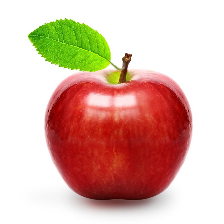

In [13]:
img = Image.open('apple.jpg')
x = transforms(img).unsqueeze(0)
out = model(x)
cls = out.argmax(dim=-1).item()
print(cls, class_names[cls])
to_img(inv_norm(x.squeeze(0), mean, std))

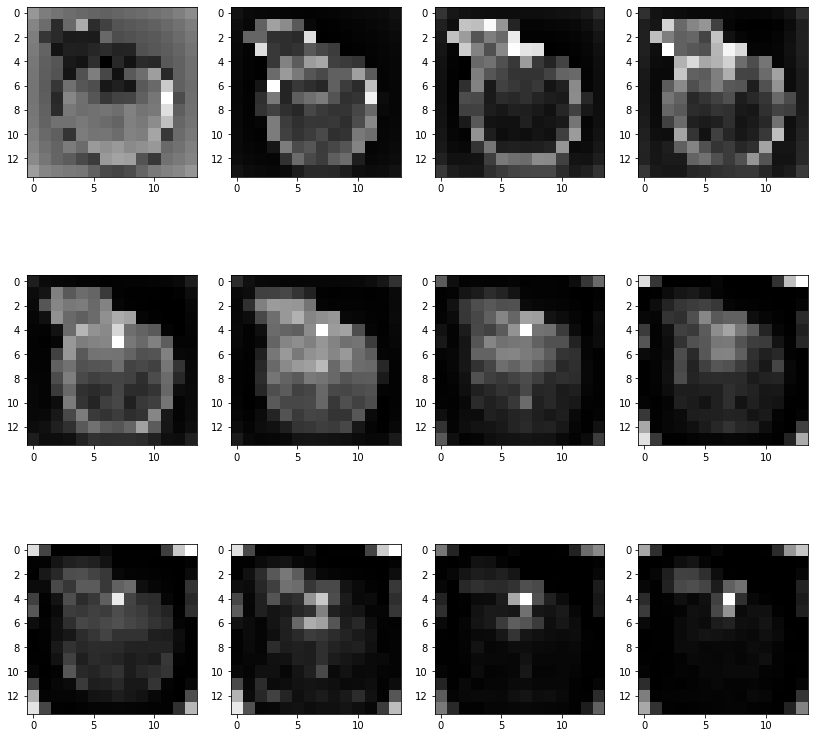

In [14]:
visualize_attn_values(model)

### Bear

3 bear


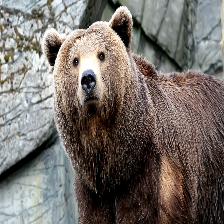

In [15]:
img = Image.open('bear.jpg')
x = transforms(img).unsqueeze(0)
out = model(x)
cls = out.argmax(dim=-1).item()
print(cls, class_names[cls])
to_img(inv_norm(x.squeeze(0), mean, std))

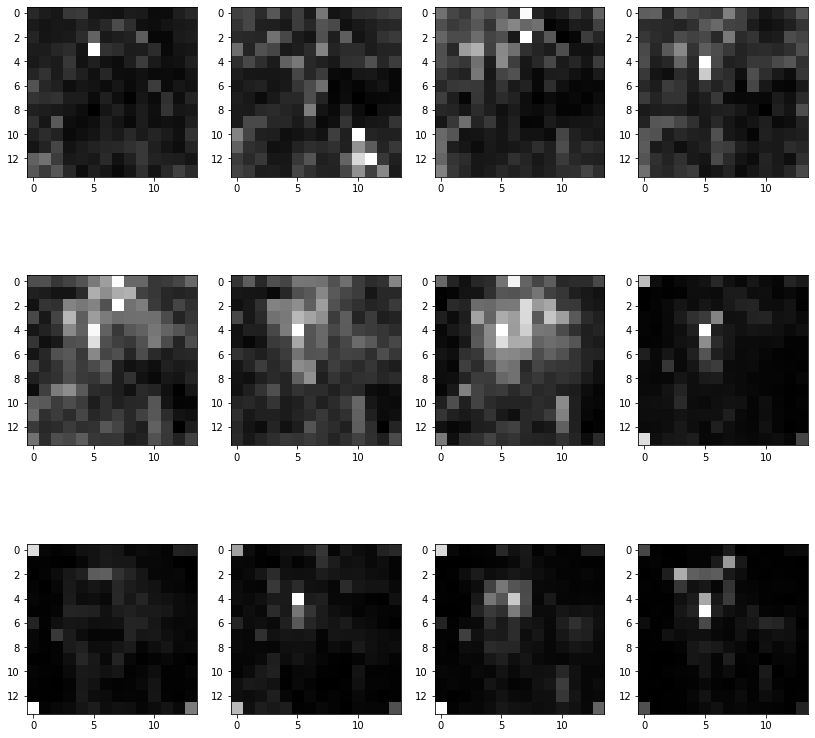

In [16]:
visualize_attn_values(model)

### Chair

20 chair


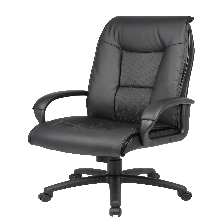

In [17]:
img = Image.open('chair.jpg')
x = transforms(img).unsqueeze(0)
out = model(x)
cls = out.argmax(dim=-1).item()
print(cls, class_names[cls])
to_img(inv_norm(x.squeeze(0), mean, std))

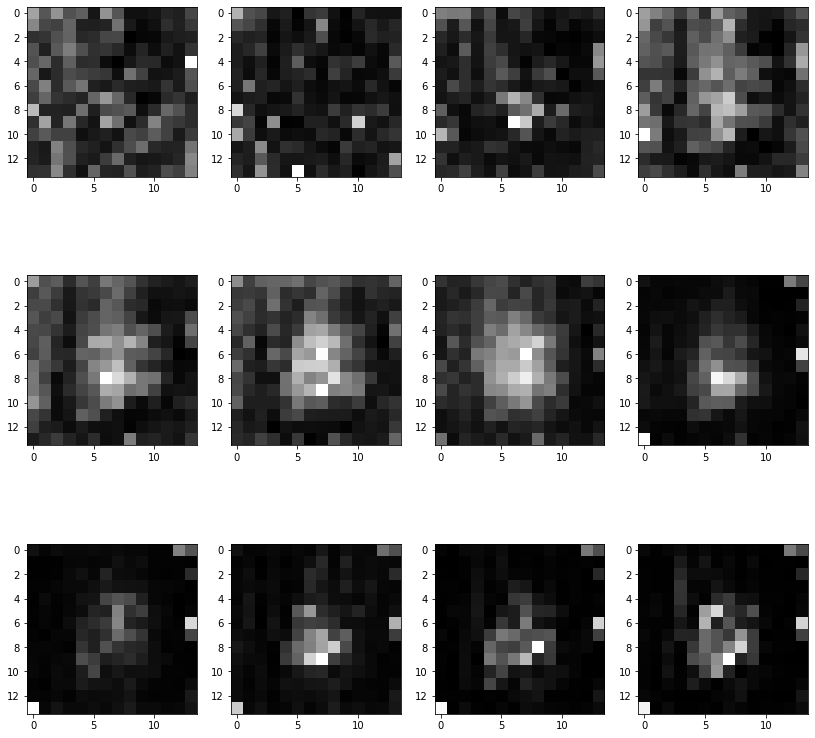

In [20]:
visualize_attn_values(model)

### Skunk

75 skunk


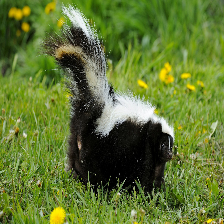

In [21]:
img = Image.open('skunk.jpg')
x = transforms(img).unsqueeze(0)
out = model(x)
cls = out.argmax(dim=-1).item()
print(cls, class_names[cls])
to_img(inv_norm(x.squeeze(0), mean, std))

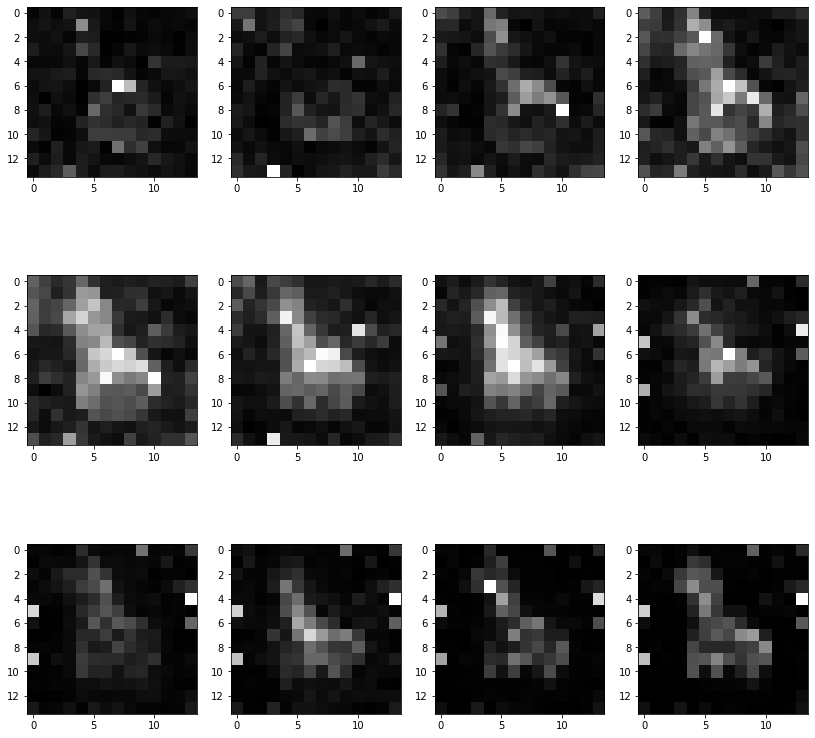

In [22]:
visualize_attn_values(model)

### Racoon

66 raccoon


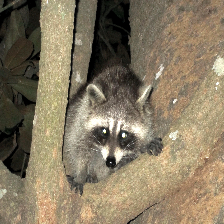

In [23]:
img = Image.open('racoon.jpg')
x = transforms(img).unsqueeze(0)
out = model(x)
cls = out.argmax(dim=-1).item()
print(cls, class_names[cls])
to_img(inv_norm(x.squeeze(0), mean, std))

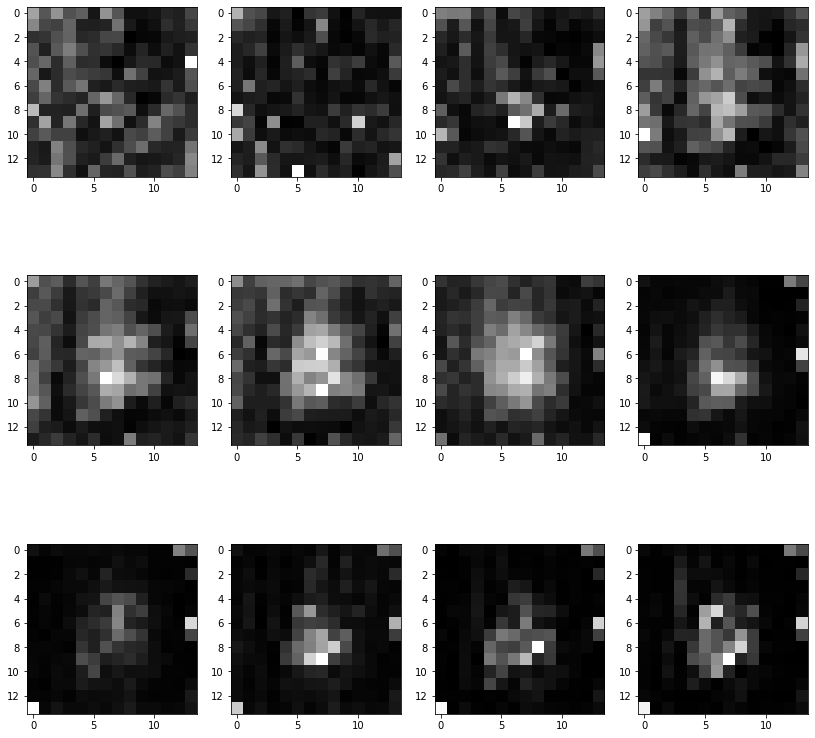

In [24]:
visualize_attn_values(model)